In [53]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

import matplotlib.pyplot as plt
from lime.lime_text import LimeTextExplainer
import shap
from collections import defaultdict
import itertools

In [46]:
# Check if TensorFlow can detect the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# load and preprocess data: cali housing

cali_housing_path = '../data/California_Houses.csv'
RANDOM_SEED = 492
cali_df = pd.read_csv(cali_housing_path)
y_series = cali_df['Median_House_Value']
y = pd.DataFrame(y_series, columns=['Median_House_Value'])
features = [col for col in cali_df.columns if col != 'Median_House_Value']
X = cali_df[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# preprocessing

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [54]:
print(len(features))

13


In [13]:
X_train_texts = X_train_scaled.astype(str).apply(' '.join, axis=1).tolist()
X_test_texts = X_test_scaled.astype(str).apply(' '.join, axis=1).tolist()

In [18]:
print(X_train_texts[0])

-0.22023367473901587 0.18302885044421452 -0.505329788280167 -0.5832710453838817 -0.625332763570887 -0.5546840263301412 1.3115180113240754 -1.6397854101401088 -0.3915220068123694 1.4909602397221111 1.4493012599111588 -0.9188291839326336 -1.2106935875117162


In [4]:
# Load the pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [41]:
class BERTRegression(Model):
    def __init__(self, max_length, hidden_size, dropout_rate=0.1, num_mc_samples=10):
        super(BERTRegression, self).__init__()
        self.max_length = max_length
        self.bert_model = TFBertModel.from_pretrained('bert-base-uncased')
        self.bert_model.trainable = True
        self.dropout = Dropout(dropout_rate)
        self.hidden_layer = Dense(hidden_size, activation='relu')
        self.mc_dropout = Dropout(dropout_rate)
        self.output_layer = Dense(1, activation='linear')
        self.num_mc_samples = num_mc_samples

    def call(self, inputs, training=False):
        input_ids, attention_mask, token_type_ids = inputs
        bert_output = self.bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[1]
        dropout_output = self.dropout(bert_output, training=training)
        hidden_output = self.hidden_layer(dropout_output)
        mc_dropout_output = self.mc_dropout(hidden_output, training=training)
        output = self.output_layer(mc_dropout_output)

        if training:
            # During training, we only need the output
            return output
        else:
            # During inference, we need the output and its sd for uncertainty
            output_samples = tf.stack([self(inputs, training=False) for _ in range(self.num_mc_samples)])
            output_mean = tf.reduce_mean(output_samples, axis=0)
            output_sd = tf.math.reduce_std(output_samples, axis=0)
            return output_mean, output_sd




In [39]:
max_length = 13  # Adjust according to your input length
hidden_size = 256  # Adjust according to your hidden layer size

In [27]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_inputs_train = tokenizer.batch_encode_plus(
    X_train_texts,
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

In [34]:
print(encoded_inputs_train)

{'input_ids': <tf.Tensor: shape=(16512, 13), dtype=int32, numpy=
array([[  101,  1011,  1014, ..., 24096, 27814,   102],
       [  101,  1015,  1012, ..., 24096,  1011,   102],
       [  101,  1014,  1012, ..., 21084,  2620,   102],
       ...,
       [  101,  1016,  1012, ..., 22610,  2581,   102],
       [  101,  1011,  1014, ...,  2683, 27814,   102],
       [  101,  1011,  1014, ...,  2581, 19317,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(16512, 13), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(16512, 13), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=in

In [43]:
bert_model = BERTRegression(max_length=max_length, hidden_size=hidden_size)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [44]:
bert_model.compile(optimizer='adam', loss='mean_squared_error')

In [48]:
# # Call the model once with dummy inputs to create the variables
# dummy_inputs = [
#     tf.zeros((1, max_length), dtype=tf.int32),
#     tf.zeros((1, max_length), dtype=tf.int32),
#     tf.zeros((1, max_length), dtype=tf.int32)
# ]
# _ = bert_model(dummy_inputs)

# Now you can safely call the `fit` method
history= bert_model.fit(
    [encoded_inputs_train['input_ids'], encoded_inputs_train['attention_mask'], encoded_inputs_train['token_type_ids']],
    y_train.values,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 221s 535ms/step - loss: 13178360832.0000 - val_loss: 12629756928.0000
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 227s 549ms/step - loss: 12628422656.0000 - val_loss: 12589022208.0000
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 236s 572ms/step - loss: 13012642816.0000 - val_loss: 12570376192.0000
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 233s 565ms/step - loss: 12631139328.0000 - val_loss: 12525213696.0000
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 227s 550ms/step - loss: 12713686016.0000 - val_loss: 12488569856.0000
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 231s 560ms/step - loss: 12822439936.0000 - val_loss: 12454757376.0000
Epoch 7/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 229s 554ms/step - loss: 12750013440.0000 - val_loss: 12428469248.0000
Epoch 8/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 226s 549ms/step - loss: 12656561152.0000 - val_loss: 12404352000.0000
Epoch 9/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 225s 545ms/step - loss: 12824104960.0000 - val_loss: 12379490304.0000
Epoch 10/1

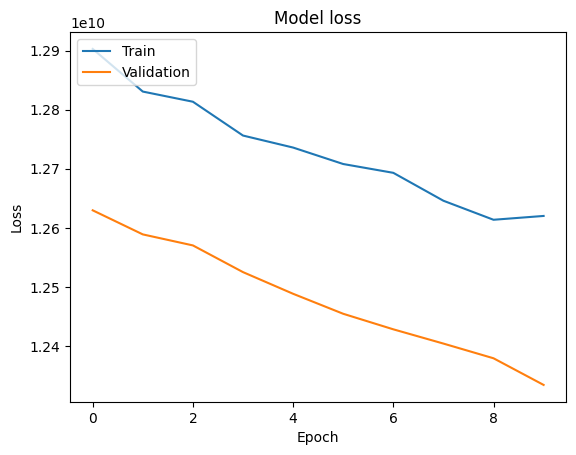

In [51]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [49]:
encoded_inputs_test = tokenizer.batch_encode_plus(
    X_test_texts,
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

In [58]:
print(encoded_inputs_test[:0])

{'input_ids': <tf.Tensor: shape=(0, 13), dtype=int32, numpy=array([], shape=(0, 13), dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(0, 13), dtype=int32, numpy=array([], shape=(0, 13), dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(0, 13), dtype=int32, numpy=array([], shape=(0, 13), dtype=int32)>}


In [55]:
def predict_function(encoded_inputs_test):
    mean_prediction, sd_prediction = bert_model.predict(
        [encoded_inputs_test['input_ids'], encoded_inputs_test['attention_mask'], encoded_inputs_test['token_type_ids']], training=False)
    return mean_prediction, sd_prediction


In [64]:
mean_prediction, sd_prediction = bert_model.predict(
        [encoded_inputs_test['input_ids'], encoded_inputs_test['attention_mask'], encoded_inputs_test['token_type_ids']])


129/129 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step


In [109]:
print(len(y_test))

4128


In [70]:
# Example test instance
instance_index = 0
X_test_instance = X_test_scaled.iloc[instance_index]
true_value = y_test.values[instance_index]

# Tokenize and encode the instance
inputs = tokenizer.encode_plus(
    ' '.join(X_test_instance.astype(str).tolist()),
    max_length=max_length,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

In [71]:
print(inputs)

{'input_ids': <tf.Tensor: shape=(1, 13), dtype=int32, numpy=
array([[  101,  1015,  1012,  5187, 28332, 14526, 10790,  2683,  2683,
        23499,  2620, 20958,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 13), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 13), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [95]:
# List to store weights for each feature
feature_weights = {feature: [] for feature in features}
# Create LIME explainer
explainer = LimeTextExplainer(class_names=features)

# Loop over test instances
for instance_index in range(len(X_test)):
    X_test_instance = X_test_scaled.iloc[instance_index]
    true_value = y_test.values[instance_index]

    # Tokenize and encode the instance
    inputs = tokenizer.encode_plus(
        ' '.join(X_test_instance.astype(str).tolist()),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    # Convert X_test_instance to a single string format that LIME expects
    text_instance = ' '.join(X_test_instance.astype(str).tolist())

    # Explain the prediction
    exp = explainer.explain_instance(
        text_instance,
        predict_function,
        num_features=len(features),
        labels=[0]
    )

    # Get the explanation for the first label
    label = exp.available_labels()[0]
    local_exp = exp.local_exp[label]

    for instance_index, instance in X_test.iterrows():
        for feature_index, feature_value in instance.iteritems():
            feature_name = X_test.columns[feature_index]
            if feature_name == 'Median_House_Value':
                continue
            feature_weights[feature_name] = feature_value
            if feature_name == 'Median_House_Value':
                continue
# Calculate the mean and standard deviation of weights for each feature
feature_stats = {feature: (np.mean(weights), np.std(weights)) for feature, weights in feature_weights.items()}

# Print the mean and standard deviation of weights for each feature
for feature, (mean_weight, std_weight) in feature_stats.items():
    print(f"Feature: {feature}, Mean Weight: {mean_weight:.3f}, Standard Deviation: {std_weight:.3f}")

AttributeError: 'Series' object has no attribute 'iteritems'

In [81]:
# Define the prediction function for LIME
def predict_function(texts):
    # Convert the input texts to tensors
    encoded_inputs = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    
    # Make predictions using the model
    predictions = bert_model([encoded_inputs['input_ids'], encoded_inputs['attention_mask'], encoded_inputs['token_type_ids']])
    
    return predictions[0].numpy()

# Create LIME explainer
explainer = LimeTextExplainer(class_names=features)

# Convert X_test_instance to a single string format that LIME expects
text_instance = ' '.join(X_test_instance.astype(str).tolist())

# Explain the prediction
exp = explainer.explain_instance(
    text_instance,  # Pass the instance as a single string
    predict_function,
    num_features=len(features),
    labels=[0]
)

In [92]:
exp.show_html()

AttributeError: 'Explanation' object has no attribute 'show_html'

In [88]:
label = exp.available_labels()[0]
top_features = exp.local_exp[label][:12]
print(f"Top 10 features for label {label}:")
for feature, weight in top_features:
    print(f"{feature}: {weight:.3f}")

Top 10 features for label 0:
0: 19273.901
1: 10295.338
2: -5943.946
5: -721.595
8: -647.615
14: 551.335
4: -433.136
10: -430.347
11: 369.826
9: -335.328


In [96]:
# List to store weights for each feature
feature_weights = {feature: [] for feature in features}

# Loop over test instances
for instance_index, instance in X_test.iterrows():
    true_value = y_test.iloc[instance_index]

    # Tokenize and encode the instance
    inputs = tokenizer.encode_plus(
        ' '.join(instance.astype(str)),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

    # Convert X_test_instance to a single string format that LIME expects
    text_instance = ' '.join(instance.astype(str))

    # Explain the prediction
    exp = explainer.explain_instance(
        text_instance,
        predict_function,
        num_features=len(features),
        labels=[0]
    )

    lime_bert = []
    lime_bert.append(exp)

TypeError: list indices must be integers or slices, not str

In [101]:
# Get the predicted value
predicted_value = exp.local_pred

# Get the local explanation
label = exp.available_labels()[0]
local_exp = exp.local_exp[label]

# Print the predicted value
print(f"Predicted value: {predicted_value}")

# Print the top features and their weights
print("Top features:")
for feature, weight in local_exp:
    print(f"- {feature}, weight: {weight:.4f}")

Predicted value: [194911.24677301]
Top features:
- 0, weight: -11644.5538
- 4, weight: -7237.4925
- 3, weight: -4562.9556
- 2, weight: -3960.2858
- 1, weight: -1903.7930
- 5, weight: -1373.4202
- 10, weight: 1015.1179
- 7, weight: -887.2533
- 18, weight: 808.1198
- 16, weight: 747.6968
- 19, weight: 729.0032
- 15, weight: 492.0135
- 12, weight: 473.2118


In [104]:
def run_multiple_inferences(instance, num_inferences):
    predictions = []
    for _ in range(num_inferences):
        inputs = tokenizer.encode_plus(
            ' '.join(instance.astype(str)),
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='tf'
        )
        model_output = bert_model([inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids']])
        prediction = model_output[0]  # Assuming the first element is the prediction
        predictions.append(prediction.numpy())
    return predictions

In [105]:
instance_index = 0
instance = X_test_scaled.iloc[instance_index]
num_inferences = 10  # Adjust this value according to your needs

# Run multiple inferences
predictions = run_multiple_inferences(instance, num_inferences)

# Store the weights for each inference
instance_weights = []
for prediction in predictions:
    # Convert the instance to a string format for LIME
    text_instance = ' '.join(instance.astype(str))

    # Get the explanation
    exp = explainer.explain_instance(
        text_instance,
        predict_function,
        num_features=len(features),
        labels=[0]
    )

    # Get the explanation for the first label
    label = exp.available_labels()[0]
    local_exp = exp.local_exp[label]

    # Store the weights for this inference
    instance_weights.append([(feature, weight) for feature, weight in local_exp])

In [106]:
# Calculate the mean and standard deviation of weights
mean_weights = {}
std_weights = {}
for feature in features:
    weights = [exp_weights[feature] for exp_weights in instance_weights]
    mean_weights[feature] = np.mean(weights)
    std_weights[feature] = np.std(weights)

# Print the mean and standard deviation of weights for this instance
for feature in features:
    print(f"Feature: {feature}, Mean Weight: {mean_weights[feature]:.3f}, Standard Deviation: {std_weights[feature]:.3f}")

TypeError: list indices must be integers or slices, not str

In [ ]:
# Sort the features by mean weight
sorted_features = sorted(mean_weights.items(), key=lambda x: x[1], reverse=True)

# Create lists for feature names, mean weights, and standard deviations
features = [feature for feature, _ in sorted_features]
mean_weights = [weight for _, weight in sorted_features]
std_weights = [std_weights[feature] for feature, _ in sorted_features]

# Set colors based on the sign of the mean weight
colors = ['lightblue' if weight > 0 else 'pink' for weight in mean_weights]

# Create a figure and plot the bar chart
fig, ax = plt.subplots(figsize=(9, 6))
feature_ids = range(len(features))
bar_plot = ax.barh(feature_ids, mean_weights, xerr=std_weights, capsize=5, alpha=0.9, color=colors)

# Add labels and title
ax.set_yticks(feature_ids)
ax.set_yticklabels(features, fontsize=12)
ax.set_xlabel("Weight", fontsize=12)
ax.set_title(f"Feature Weights for Instance {instance_index}", fontsize=14)

# Rotate y-axis labels for better visibility
plt.subplots_adjust(left=0.3)
plt.tight_layout()